In [1]:
import os
import sys
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import scipy.stats as scs
import seaborn as sb
import dvc.api
import mlflow
import mlflow.sklearn
warnings.filterwarnings("ignore")

In [2]:
# set up paths and helper scripts
sys.path.append('.')
sys.path.insert(1, '../scripts/')

import defaults as defs
import dataCleaner as dc
import dataVisualizer as dv
import abTestHelper as th
import mlHelper as mlh

# setup helper scripts
cleaner = dc.dataCleaner('ml hypothesis testing notebook')
visualizer = dv.dataVisualizer('ml hypothesis testing notebook')
abTestHelper = th.abTestHelper('ml hypothesis testing notebook')
mlHelper = mlh.machineLearningHelper('ml hypothesis testing notebook')

--> <Logger dataCleaner (WARNING)>
logger <Logger dataCleaner (INFO)> created at path: ../logs/cleaner_root.log
Data cleaner in action
--> <Logger dataVisualizer (WARNING)>
logger <Logger dataVisualizer (INFO)> created at path: ../logs/visualizer_root.log
Data visualizer in action
--> <Logger abTestHelper (WARNING)>
logger <Logger abTestHelper (INFO)> created at path: ../logs/hypothesis_test_root.log
Hypothesis test helper in action
--> <Logger mlHelper (WARNING)>
logger <Logger mlHelper (INFO)> created at path: ../logs/ml_preprocess_root.log
Data preprocessor in action


In [3]:
# read data using dvc
version = 'v1'

# data path using dvc api
data_url = dvc.api.get_url(path = defs.path, 
                           repo = defs.repo, 
                           rev = version)

# reading the csv file
missing_values = ["n/a", "na", "undefined", '?', 'NA', 'undefined']
df = pd.read_csv(data_url, na_values=missing_values)
df

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
...,...,...,...,...,...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,2020-07-04,9,Generic Smartphone,6,Chrome Mobile,0,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,2020-07-05,15,Samsung SM-A515F,6,Samsung Internet,0,0


# ML hypothesis testing

## Preprocessing 

In [4]:
# setting up ml flow experiment
mlflow.set_experiment('data preparation')
mlflow.start_run()

mlflow.log_param('data_url', data_url)
mlflow.log_param('data_version', version)
mlflow.log_param('input_rows', df.shape[0])
mlflow.log_param('input_cols', df.shape[1])

### prepare data for ml

* Drop non BIO participants

In [5]:
drop_cols = df.query('yes == 0 and no ==0')
df = df.drop(drop_cols.index)
df

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,1
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1
...,...,...,...,...,...,...,...,...,...
8059,ffa08ff9-a132-4051-aef5-01a9c79367bc,exposed,2020-07-05,21,Generic Smartphone,6,Chrome Mobile,1,0
8063,ffb176df-ecd2-45d3-b05f-05b173a093a7,exposed,2020-07-04,1,Generic Smartphone,6,Chrome Mobile,1,0
8064,ffb79718-6f25-4896-b6b3-e58b80a6e147,control,2020-07-09,7,Generic Smartphone,6,Chrome Mobile,0,1
8069,ffca1153-c182-4f32-9e90-2a6008417497,control,2020-07-10,16,Generic Smartphone,6,Chrome Mobile,0,1


* Drop auction id

In [6]:
df = cleaner.remove_unwanted_cols(df, ['auction_id'])
df

,experiment,date,hour,device_make,platform_os,browser,yes,no
2,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
16,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
20,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,1
23,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
27,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1
...,...,...,...,...,...,...,...,...
8059,exposed,2020-07-05,21,Generic Smartphone,6,Chrome Mobile,1,0
8063,exposed,2020-07-04,1,Generic Smartphone,6,Chrome Mobile,1,0
8064,control,2020-07-09,7,Generic Smartphone,6,Chrome Mobile,0,1
8069,control,2020-07-10,16,Generic Smartphone,6,Chrome Mobile,0,1


* Adding awareness column to the data set (target feature)

In [7]:
df['awareness'] = df.apply(lambda row: mlHelper.label_awareness(row), axis=1) 
df.reset_index(drop=True, inplace=True)
df

,experiment,date,hour,device_make,platform_os,browser,yes,no,awareness
0,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1,0
1,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0,1
2,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,1,0
3,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0,1
4,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1,0
...,...,...,...,...,...,...,...,...,...
1238,exposed,2020-07-05,21,Generic Smartphone,6,Chrome Mobile,1,0,1
1239,exposed,2020-07-04,1,Generic Smartphone,6,Chrome Mobile,1,0,1
1240,control,2020-07-09,7,Generic Smartphone,6,Chrome Mobile,0,1,0
1241,control,2020-07-10,16,Generic Smartphone,6,Chrome Mobile,0,1,0


* Save the awareness (target) added data set

In [8]:
df.to_csv(defs.local_path, index = False)
mlflow.log_artifact(defs.local_path)

* Transform categorical variables to numerical variables

In [9]:
# change categorical variables to numerical value
categorical_columns = (df.dtypes == object)
categorical_columns = categorical_columns[categorical_columns == True].index
df = mlHelper.encode_to_numeric(data = df, columns = categorical_columns)
df

,experiment,date,hour,device_make,platform_os,browser,yes,no,awareness
0,1,2,2,4,6,2,0,1,0
1,1,1,16,13,6,1,1,0,1
2,1,3,8,13,6,1,0,1,0
3,0,5,4,43,6,4,1,0,1
4,0,0,15,13,6,1,0,1,0
...,...,...,...,...,...,...,...,...,...
1238,1,2,21,13,6,1,1,0,1
1239,1,1,1,13,6,1,1,0,1
1240,0,6,7,13,6,1,0,1,0
1241,0,7,16,13,6,1,0,1,0


* Save the transformed data

In [10]:
df.to_csv(defs.local_path, index = False)
mlflow.log_artifact(defs.local_path)

* Split data to browser and platform os

* Browser

In [11]:
browser_df = df[["experiment", "hour", "date", 'device_make', 'browser', 'awareness']]
browser_df.to_csv(defs.local_path, index = False)
mlflow.log_artifact(defs.local_path)
browser_df

,experiment,hour,date,device_make,browser,awareness
0,1,2,2,4,2,0
1,1,16,1,13,1,1
2,1,8,3,13,1,0
3,0,4,5,43,4,1
4,0,15,0,13,1,0
...,...,...,...,...,...,...
1238,1,21,2,13,1,1
1239,1,1,1,13,1,1
1240,0,7,6,13,1,0
1241,0,16,7,13,1,0


* Platform os

In [12]:
platform_df = df[["experiment", "hour", "date", 'device_make', 'platform_os', 'awareness']]
platform_df.to_csv(defs.local_path, index = False)
mlflow.log_artifact(defs.local_path)
platform_df

,experiment,hour,date,device_make,platform_os,awareness
0,1,2,2,4,6,0
1,1,16,1,13,6,1
2,1,8,3,13,6,0
3,0,4,5,43,6,1
4,0,15,0,13,6,0
...,...,...,...,...,...,...
1238,1,21,2,13,6,1
1239,1,1,1,13,6,1
1240,0,7,6,13,6,0
1241,0,16,7,13,6,0


In [13]:
mlflow.end_run()

## Modeling

In [3]:
#imports
from datetime import datetime
import joblib

import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, cross_validate

* Platform os split: version 4 of the dataset

* Browser split: version 5 of the dataset

In [4]:
# TODO : refactor this 
# read data using dvc
version = 'v4'

# data path using dvc api
data_url = dvc.api.get_url(path = defs.path, 
                           repo = defs.repo, 
                           rev = version)

# reading the csv file
missing_values = ["n/a", "na", "undefined", '?', 'NA', 'undefined']
df = pd.read_csv(data_url, na_values=missing_values)
df

,Unnamed: 0,experiment,hour,date,device_make,platform_os,awareness
0,0,1,2,2,4,6,0
1,1,1,16,1,13,6,1
2,2,1,8,3,13,6,0
3,3,0,4,5,43,6,1
4,4,0,15,0,13,6,0
...,...,...,...,...,...,...,...
1238,1238,1,21,2,13,6,1
1239,1239,1,1,1,13,6,1
1240,1240,0,7,6,13,6,0
1241,1241,0,16,7,13,6,0


* Clean unwanted rows

In [5]:
df = cleaner.remove_unwanted_cols(df, ['Unnamed: 0'])

In [6]:
df

,experiment,hour,date,device_make,platform_os,awareness
0,1,2,2,4,6,0
1,1,16,1,13,6,1
2,1,8,3,13,6,0
3,0,4,5,43,6,1
4,0,15,0,13,6,0
...,...,...,...,...,...,...
1238,1,21,2,13,6,1
1239,1,1,1,13,6,1
1240,0,7,6,13,6,0
1241,0,16,7,13,6,0


In [7]:
# setting up ml flow experiment
mlflow.set_experiment('ml modeling')
mlflow.start_run()

mlflow.log_param('data_url', data_url)
mlflow.log_param('data_version', version)
mlflow.log_param('input_rows', df.shape[0])
mlflow.log_param('input_cols', df.shape[1])

### Training models

* Platform os split: version 4 of the dataset

* Browser split: version 5 of the dataset

In [8]:
# set up the data, differentiating the training features and the target
X = df.iloc[: , :-1]
y = df.iloc[: , -1]

In [9]:
mlflow.log_param('features', X.columns.to_list())
mlflow.log_param('target', 'awareness')

### Cross validation: 5 folds 

* Using shuffle split and defining scoring metrics

In [10]:
# shuffle split using 5 folds and tet size of 2%
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 77)

# scoring metrics
#long_scoring = ['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'accuracy', 'precision', 'recall', 'f1',  'neg_log_loss']
scoring = ['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'accuracy', 'precision']
mlflow.log_param('scoring', scoring)
mlflow.log_param('cross_validation', cv)

#### Classifier one: logistic regression

In [11]:
# logistic regression parameters
log_reg_params = {'random_state' : 77}

# logistic regression classifier pipeline
log_reg_pipeline = Pipeline([("scaler", preprocessing.StandardScaler()),
                            ('log_reg_classifier', LogisticRegression(random_state = 77))])

# logistic regression classifier cross validation
log_reg_results = cross_validate(log_reg_pipeline, X, y, cv = cv, scoring = scoring, 
                                return_train_score = False, return_estimator = False)
# save the model
joblib.dump(log_reg_pipeline._final_estimator, '../models/log_reg_model.pkl')

# logging parameters, models and metrics
mlflow.log_param('log reg parameters', log_reg_params)
mlflow.log_artifact("../models/log_reg_model.pkl")
# mlflow.log_metric('log reg metrics', log_reg_results)

#### Classifier two: decision tree

In [12]:
# decision tree parameters
decision_tree_params = {'random_state' : '77'}

# decision tree classifier pipeline
decision_tree_pipeline = Pipeline([('scaler', preprocessing.StandardScaler()),
                                ('decision_tree_classifier', DecisionTreeClassifier(random_state = 77))])

# decision tree classifier cross validation
decision_tree_results = cross_validate(decision_tree_pipeline, X, y, cv = cv, scoring = scoring, 
                                return_train_score = False, return_estimator = False)
# save the model
joblib.dump(decision_tree_pipeline._final_estimator, '../models/decision_tree_model.pkl')

# logging parameters, models and metrics
mlflow.log_param('decision tree parameters', decision_tree_params)
mlflow.log_artifact("../models/decision_tree_model.pkl")
# mlflow.log_metric('decision tree metrics', decision_tree_results)

#### Classifier three: XGB

In [13]:
# xgb parameters
xgb_params = {"objective":"binary:logistic", 'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

# convert the dataset into an optimized data structure named Dmatrix that XGB supports
data_dmatrix = xgb.DMatrix(data = X, label = y)

# XGBoost classifier cross validation
xgb_results = xgb.cv(dtrain = data_dmatrix, params = xgb_params, nfold = 5,
                        num_boost_round = 50, early_stopping_rounds = 10, 
                        metrics = "rmse", as_pandas=True, seed=77)

xg_class = xgb.train(dtrain = data_dmatrix, params = xgb_params, num_boost_round = 50)

# save the model
joblib.dump(xg_class, '../models/xgb_classification_model.pkl')

# logging parameters, models and metrics
mlflow.log_param('xgb parameters', xgb_params)
mlflow.log_artifact("../models/xgb_classification_model.pkl")
# mlflow.log_metric('xgb metrics', xgb_results)

### Metrics report

In [14]:
# Mean report for all three classifier
mlHelper.print_result(log_reg_results, scoring, 'mean')
mlHelper.print_result(decision_tree_results, scoring, 'mean')
xgb_results.head()


--- Mean Report ---
fit time: 0.0867
score time: 0.0141
test_r2: -0.8194
test_neg_mean_squared_error: -0.4506
test_neg_root_mean_squared_error: -0.6707
test_neg_mean_absolute_error: -0.4506
test_accuracy: 0.5494
test_precision: 0.5536

--- Mean Report ---
fit time: 0.0636
score time: 0.0188
test_r2: -0.9378
test_neg_mean_squared_error: -0.4795
test_neg_root_mean_squared_error: -0.6923
test_neg_mean_absolute_error: -0.4795
test_accuracy: 0.5205
test_precision: 0.4705


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.499761,0.000103,0.499822,0.000135
1,0.499561,0.000188,0.499681,0.000263
2,0.499394,0.000258,0.499567,0.000384
3,0.499164,0.000335,0.499512,0.000491
4,0.498969,0.000377,0.499431,0.000623


In [15]:
# Standard deviation report for all three classifiers
mlHelper.print_result(log_reg_results, scoring, 'std')
mlHelper.print_result(decision_tree_results, scoring, 'std')


--- Standard deviation Report ---
fit time: 0.1122
score time: 0.0029
test_r2: 0.1347
test_neg_mean_squared_error: 0.0375
test_neg_root_mean_squared_error: 0.0284
test_neg_mean_absolute_error: 0.0375
test_accuracy: 0.0375
test_precision: 0.1

--- Standard deviation Report ---
fit time: 0.0917
score time: 0.0035
test_r2: 0.0893
test_neg_mean_squared_error: 0.0218
test_neg_root_mean_squared_error: 0.0158
test_neg_mean_absolute_error: 0.0218
test_accuracy: 0.0218
test_precision: 0.0387


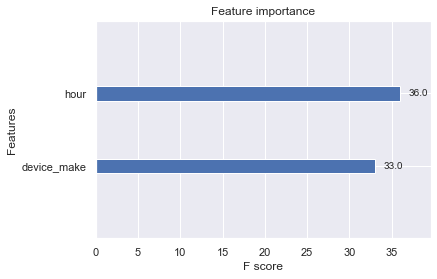

In [16]:
# feature importance
xgb.plot_importance(xg_class)
plt.rcParams['figure.figsize'] = [120, 70]
plt.show()

# mlflow.log_artifact('feature importance', plt)

In [ ]:
mlflow.end_run()